In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import circularFiltering as flt
from scipy.stats import vonmises
from scipy.special import i0, i1
from scipy.stats import norm
import circularFiltering as flt
import matplotlib
import glob
import os
import re
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

## Figure 3b + inset - Performance as function of information content

In [2]:
preprocess = False # only set to True if you want to re-run preprocessing on data in /data_raw

path_raw = 'data_raw/figure2i/'
path_processed = 'data_processed/'

In [3]:
kappa_z_array = ([1.e-02, 3.e-02, 1.e-01, 2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01,
       7.e-01, 8.e-01, 9.e-01, 1.e+00, 2.e+00, 3.e+00, 4.e+00, 5.e+00,
       6.e+00, 7.e+00, 8.e+00, 9.e+00, 1.e+01, 3.e+01, 1.e+02])

kappa_array = np.array([  0.1,   0.3,   0.9,   1. ,   1.1,   1.2,   1.3,   1.4,   1.5,
         1.6,   1.7,   1.8,   1.9,   2. ,   2.1,   2.2,   2.3,   2.4,
         2.5,   2.6,   2.7,   2.8,   2.9,   3. ,   4. ,   5. ,   6. ,
         7. ,   8. ,   9. ,  10. ,  30. , 100. ])


if preprocess:

    # # make unique list of parameter values
    fileNames = glob.glob(os.path.join(path_raw, "k=*.npz"))
    kappa_array = np.array( [ re.findall('(?<=k=)(.*)(?=_)', name) for name in fileNames ] )[:,0]
    kappa_array = np.unique(kappa_array.astype(float))
    kappa_z_array = np.array( [ re.findall('(?<=kz=)(.*)(?=\.)', name) for name in fileNames ] )[:,0]
    kappa_z_array = np.unique(kappa_z_array.astype(float))


    len_kz = len(kappa_z_array)
    len_k = len(kappa_array)

    phi = np.zeros([len_k,len_kz])
    vonMises_stats = np.zeros([len_k,len_kz,3]) # 1st (bias + variance) and 2nd order statistics for each kappa_z,
    vonMises_q_stats = np.zeros([len_k,len_kz,3])
    PF_stats = np.zeros([len_k,len_kz,3])
    noUncert_stats = np.zeros([len_k,len_kz,2])

    for i in np.arange(len_k):
        if i == 0:
            for j in np.arange(len_kz):
                kappa = kappa_array[i]
                kappa_z = kappa_z_array[j]
                filename = path_raw+"k="+str(kappa)+"_kz="+str(kappa_z)
                data = np.load(filename+'.npz')

                # simulation data arrays, mean and kappa (r for PF) for each run
                vonMises=data['vonMises']
                vonMises_q=data['vonMises_q']
                noUncert = data['noUncert']
                PF=data['PF']
                phi_final = data['phi_final']

                # collect 2nd order statistics at end of simulation(precision as computed by filter)
                vonMises_stats[i,j,2] = np.mean(vonMises[:,1])
                vonMises_q_stats[i,j,2] = np.mean(vonMises_q[:,1])
                PF_stats[i,j,2] = np.mean(PF[:,1])


                # collect 1st order statistics (bias as phase of circular mean, precision as radius of circular mean)
                vonMises_stats[i,j,[0,1]] = flt.circular_mean(flt.backToCirc(vonMises[:,0]-phi_final))
                vonMises_q_stats[i,j,[0,1]] = flt.circular_mean(flt.backToCirc(vonMises_q[:,0]-phi_final))
                PF_stats[i,j,[0,1]] = flt.circular_mean(flt.backToCirc(PF[:,0]-phi_final))
                noUncert_stats[i,j] = flt.circular_mean(flt.backToCirc(noUncert - phi_final))

        else:
            for j in np.arange(len_kz):
                kappa = kappa_array[i]
                kappa_z = kappa_z_array[j]
                filename = path_raw+"k="+str(kappa)+"_kz="+str(kappa_z)
                data = np.load(filename+'.npz')

                noUncert = data['noUncert']
                phi_final = data['phi_final']

                # collect 1st order statistics (bias as phase of circular mean, precision as radius of circular mean)
                noUncert_stats[i,j] = flt.circular_mean(flt.backToCirc(noUncert - phi_final))
    
    # save the preprocessed data
    np.savez(path_processed+'figure2i',
        vonMises_stats=vonMises_stats,vonMises_q_stats=vonMises_q_stats,PF_stats=PF_stats,noUncert_stats=noUncert_stats)

else:
    data = np.load(path_processed+'figure2i.npz')
    vonMises_stats = data['vonMises_stats']
    vonMises_q_stats = data['vonMises_q_stats']
    PF_stats = data['PF_stats']
    noUncert_stats = data['noUncert_stats']


In [4]:
mu_perf = 0.5
sig_perf = 1

def objective(rMSE,mu=0,sigma=0.5):
    x = np.log(kappa_z_array)
    dx = np.diff(x)
    f = rMSE * norm.pdf(x,loc=mu,scale=sigma)
    rMSE_avg = np.sum( 1/2*(f[1:] + f[:-1] ) * dx ) # trapezoidal rule for irregular grid spacing
    return rMSE_avg

In [5]:
# determine reference value for overall performance
ref_PF = objective(PF_stats[0,:,1],mu=mu_perf,sigma=sig_perf)
ref_PF

0.6912447327304075

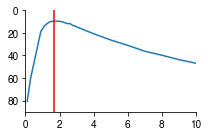

In [6]:

MSE_array = np.array([ objective(noUncert_stats[i,:,1],mu=mu_perf,sigma=sig_perf) for i in np.arange(len(kappa_array))])
idx_best = np.argmax(MSE_array)
best_kappastar = kappa_array[idx_best]

performance = 100 - MSE_array/ref_PF * 100

# relative to reference
fig, ax1 = plt.subplots(ncols=1,nrows=1,figsize = (3,2),sharex=True,tight_layout=True)
ax1.plot(kappa_array,performance)
ax1.plot([best_kappastar,best_kappastar],[0,100],c='red')
ax1.set_xlim([0,10])
ax1.set_ylim([0,90])
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.invert_yaxis()
# plt.savefig('figure6/fixedkappaflt_performance.pdf',format='pdf',transparent=True)
plt.show()

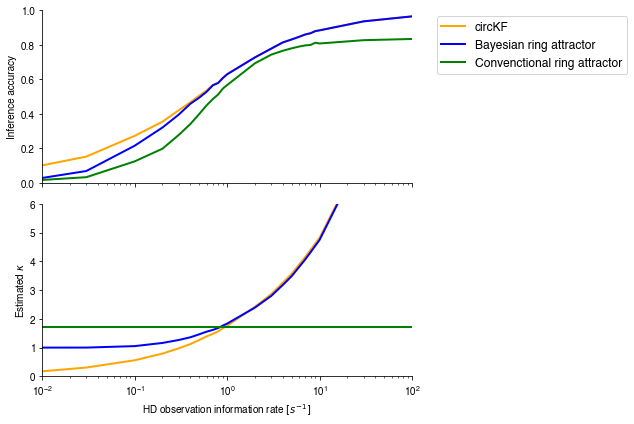

In [7]:
fig, (ax1,ax2) = plt.subplots(ncols=1,nrows=2,figsize = (9,6),sharex=True,tight_layout=True)

i = np.argmax(MSE_array)
ax1.plot(kappa_z_array,vonMises_stats[0,:,1],label='circKF',linewidth=2,color='orange')
ax1.plot(kappa_z_array,vonMises_q_stats[0,:,1],label='Bayesian ring attractor',linewidth=2,color='blue')
ax1.plot(kappa_z_array,noUncert_stats[i,:,1],label=r'Convenctional ring attractor',linewidth=2,color='green')
ax1.set_ylabel(r'Inference accuracy')
ax1.set_xscale('log')
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_ylim([0,1])
ax1.set_xlim([kappa_z_array[0],kappa_z_array[-1]])
ax1.legend(prop={"size":12},loc='upper left',bbox_to_anchor=(1.05, 1.0))

ax2.plot(kappa_z_array,vonMises_stats[0,:,2],label='circKF',linewidth=2,color='orange')
ax2.plot(kappa_z_array,vonMises_q_stats[0,:,2],label='Bayesian ring attractor',linewidth=2,color='blue')
ax2.plot([kappa_z_array[0],kappa_z_array[-1]],[kappa_array[i],kappa_array[i]],label=r'Conventional ring attractor',linewidth=2,color='green')
ax2.set_ylabel(r'Estimated $\kappa$')
ax2.set_xlabel(r'HD observation information rate $[s^{-1}]$')
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_ylim([0,6])
plt.show()

## Figure 3c and Figure S3 - $\Delta \mu$ as function of info content

In [8]:
kappa_z_array_old = np.copy(kappa_z_array)
kappa_z_array_old

array([1.e-02, 3.e-02, 1.e-01, 2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01,
       7.e-01, 8.e-01, 9.e-01, 1.e+00, 2.e+00, 3.e+00, 4.e+00, 5.e+00,
       6.e+00, 7.e+00, 8.e+00, 9.e+00, 1.e+01, 3.e+01, 1.e+02])

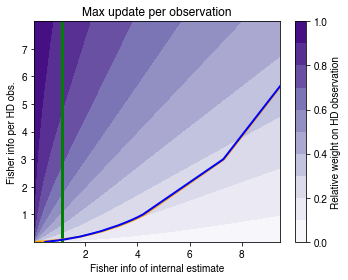

In [9]:
fig, (ax1) = plt.subplots(ncols=1,nrows=1,figsize = (5,4),sharex=True,tight_layout=True)
dt = 0.1
kappa_array = np.arange(0.2,10,0.01) # own uncertainty right before update
kappa_z_array =  np.arange(0.1,80,0.1) # information rate of observations
alpha_array = np.array( [ flt.xi_fun_inv(kappa_z * dt) for kappa_z in kappa_z_array] )
kappa, alpha = np.meshgrid(kappa_array, alpha_array)
dmu = np.arctan2(alpha,kappa)
CS = ax1.contourf( flt.xi(kappa_array), kappa_z_array * dt, dmu/(0.5*np.pi), levels=10, cmap='Purples')
ax1.plot([flt.xi(best_kappastar),flt.xi(best_kappastar)],[0,10],color='green',linewidth=3)
ax1.plot(flt.xi(vonMises_stats[0,:,2]), kappa_z_array_old * dt,label='Projection Filter',linewidth=2,color='orange')
ax1.plot(flt.xi(vonMises_q_stats[0,:,2]), kappa_z_array_old * dt,label='Q Apppr',linewidth=2,color='blue')

ax1.set_xlim([flt.xi(kappa_array[0]),flt.xi(kappa_array[-1])])
ax1.set_ylim([kappa_z_array[0]*dt,kappa_z_array[-1]*dt])
cbar = plt.colorbar(CS)
cbar.set_label('Relative weight on HD observation')
ax1.set_xlabel('Fisher info of internal estimate')
ax1.set_ylabel('Fisher info per HD obs.')
ax1.set_title('Max update per observation')
plt.show()

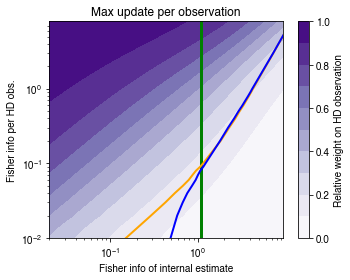

In [10]:
fig, (ax1) = plt.subplots(ncols=1,nrows=1,figsize = (5,4),sharex=True,tight_layout=True)
dt = 0.1
kappa_array = np.arange(0.2,10,0.01) # own uncertainty right before update
kappa_z_array =  np.arange(0.1,80,0.1) # information rate of observations
alpha_array = np.array( [ flt.xi_fun_inv(kappa_z * dt) for kappa_z in kappa_z_array] )
kappa, alpha = np.meshgrid(kappa_array, alpha_array)
dmu = np.arctan2(alpha,kappa)
CS = ax1.contourf( flt.xi(kappa_array), kappa_z_array * dt, dmu/(0.5*np.pi), levels=10, cmap='Purples')
ax1.plot([flt.xi(best_kappastar),flt.xi(best_kappastar)],[0,10],color='green',linewidth=3)
ax1.plot(flt.xi(vonMises_stats[0,:,2]), kappa_z_array_old * dt,label='Projection Filter',linewidth=2,color='orange')
ax1.plot(flt.xi(vonMises_q_stats[0,:,2]), kappa_z_array_old * dt,label='Q Apppr',linewidth=2,color='blue')

ax1.set_xlim([flt.xi(kappa_array[0]),flt.xi(kappa_array[-1])])
ax1.set_ylim([kappa_z_array[0]*dt,kappa_z_array[-1]*dt])
cbar = plt.colorbar(CS)
cbar.set_label('Relative weight on HD observation')
ax1.set_xlabel('Fisher info of internal estimate')
ax1.set_ylabel('Fisher info per HD obs.')
ax1.set_title('Max update per observation')
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.show()

## Figure 3d - Performance of Bayesian ring attractor with varying network paramters

In [11]:
preprocess = False # only set to True if you want to re-run preprocessing on data in /data_raw

path_raw = 'data_raw/figure3d/'
path_processed = 'data_processed/'

In [12]:
kappa_star_array = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5])
beta_array = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1, 2 ,4 ,8])
kappa_z_array = np.array([1.e-02, 3.e-02, 1.e-01, 2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01,
       7.e-01, 8.e-01, 9.e-01, 1.e+00, 2.e+00, 3.e+00, 4.e+00, 5.e+00,
       6.e+00, 7.e+00, 8.e+00, 9.e+00, 1.e+01, 3.e+01, 1.e+02])

if preprocess:
       MSE_array = np.zeros((len(kappa_star_array),len(beta_array)))
       for i in np.arange(len(kappa_star_array)):
              for j in np.arange(len(beta_array)):
                     filename = path_raw+"ntwkflt_k="+str(kappa_star_array[i])+"_beta="+str(beta_array[j])
                     data = np.load(filename+'.npz')
                     stats = data['stats']
                     MSE_array[i,j] = objective( stats[:,1] ,mu=mu_perf,sigma=sig_perf) 

    
       # save the preprocessed data
       np.savez(path_processed+'figure3d',
              stats=stats,MSE_array=MSE_array)
else:
       data = np.load(path_processed+'figure3d.npz')
       stats = data['stats']
       MSE_array = data['MSE_array']

# normalize
MSE_array = MSE_array/ref_PF

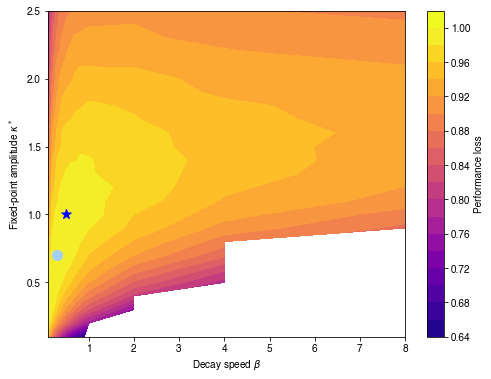

In [13]:
idx = np.where(MSE_array == np.nanmax(MSE_array))

fig, ax = plt.subplots(1,1,figsize=(8,6))
CS = ax.contourf(beta_array,kappa_star_array,MSE_array,levels=21,vmax=1,cmap='plasma')
ax.scatter(beta_array[idx[1]],kappa_star_array[idx[0]],s=100,color='xkcd:baby blue')
ax.scatter(0.5,1,marker='*',s=100,c='blue')
cbar = plt.colorbar(CS)
cbar.set_label('Performance loss')

ax.set_xlabel(r'Decay speed $\beta$')
ax.set_ylabel(r'Fixed-point amplitude $\kappa^*$')
plt.show()

## Figure 3e - Comparison of different networks/filters as trajectories

In [14]:
# model parameters
T = 10 # simulation time
dt = 0.01 # step size
t = np.arange(0,T,dt)
timesteps = int(T/dt)
kappa_phi = 1 # inverse diffusion constant
phi_0 = 0 # initial mean
kappa_0 = 2 # initial certainty
kappa_y = 1 # certainty of increment observations
kappa_z = 1 # observation certainty
alpha = flt.xi_fun_inv(kappa_z * dt)

np.random.seed(8)

# parameters of best model, network-like
kstar = kappa_star_array[idx[0]]
bstar = beta_array[idx[1]]

# generate data
phi, dy, z = flt.generateData(T,kappa_phi,kappa_y=kappa_y,dt=dt,phi_0=phi_0,kappa_0=kappa_0,kappa_z=alpha)

# Particle Filter
N = 1000
mu_PF, r_PF = flt.PF_run(T,N,kappa_phi,dy=dy,z=z,kappa_z=alpha,
                        kappa_y=kappa_y,phi_0=phi_0,kappa_0=kappa_0,dt=dt)

# von Mises projection filter (circKF)
mu_VM, kappa_VM = flt.vM_Projection_Run(T,kappa_phi,dy=dy,kappa_y=kappa_y,z=z,kappa_z=alpha,
                        phi_0=phi_0,kappa_0=kappa_0,dt=dt)

# von Mises projection filter, circKF with quadratic approximation
mu_VMq, kappa_VMq = flt.vM_Projection_quad_Run(T,kappa_phi,dy=dy,kappa_y=kappa_y,z=z,kappa_z=alpha,
                        phi_0=phi_0,kappa_0=kappa_0,dt=dt)


# uncertainty-free filter (fixed kappa*)
kappa_nu = best_kappastar
mu_noUncert = flt.no_uncertainty_filter_Run(T,kappa_nu,kappa_phi,dy=dy,kappa_y=kappa_y,z=z,kappa_z=alpha,
                        phi_0=phi_0,kappa_0=kappa_0,dt=dt)


# network-like filter (translate beta and kappa* to network parameters, see SI)
kappa_star = kstar # desired fixed point
# beta = 1/(kappa_phi+kappa_y) # effective inverse time constant
beta = bstar
tau = 1
w_even = beta + 1/tau
w_quad = beta / kappa_star
w_odd = kappa_y/(kappa_phi+kappa_y)
I_ext = alpha
# stoch_corr = 1/2 * kappa_y/kappa_phi * 1/(kappa_phi + kappa_y)
mu_net, kappa_net = flt.network_filter_Run(T,w_even=w_even,w_odd=w_odd,tau=tau,w_quad=w_quad,
                        I_ext=I_ext,z=z,dy=dy,phi_0=phi_0,kappa_0=kappa_0,dt=dt)

(0.0, 3.75)

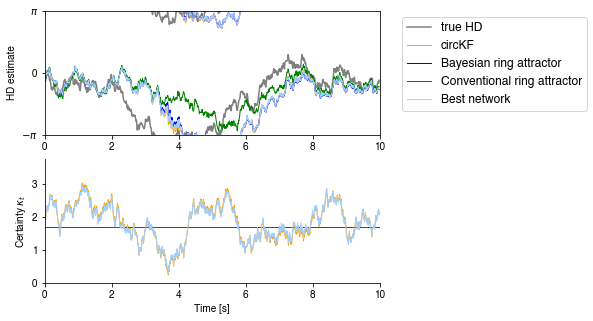

In [15]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,5))

ax1.plot(*flt.circplot(t,phi),label='true HD',color='grey')
ax1.plot(*flt.circplot(t,mu_VM),label='circKF',color='orange',linewidth=1)
ax1.plot(*flt.circplot(t,mu_VMq),label='Bayesian ring attractor',color='blue',linewidth=1)
ax1.plot(*flt.circplot(t,mu_noUncert),label=r'Conventional ring attractor',color='green',linewidth=1)
ax1.plot(*flt.circplot(t,mu_net),label=r'Best network',color='xkcd:baby blue',linewidth=1)
ax1.legend(loc='upper left')
ax1.set_yticks([-np.pi,0,np.pi])
ax1.set_yticklabels(['$-\pi$',0,'$\pi$'])
ax1.set_xlim([0,T])
ax1.set_ylim([-np.pi,np.pi])
ax1.set_ylabel('HD estimate')
ax1.legend(prop={"size":12},loc='upper left',bbox_to_anchor=(1.05, 1.0))

ax2.plot(t,kappa_VM,label='vM',color='orange',linewidth=1)
# ax2.plot(t,kappa_VMq,label='vMq',color='blue',linewidth=1)
ax2.plot(t,kappa_nu*np.ones(len(t)),label=r'$\kappa*=$'+str(kappa_nu),color='green',linewidth=1)
ax2.plot(t,kappa_net,label=r'$\kappa*=$'+str(kappa_star)+r',$\beta$='+str(beta),color='xkcd:baby blue',linewidth=1)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_ylabel(r'Certainty $\kappa_t$')
ax2.set_xlabel('Time [s]')
ax2.set_xlim([0,T])
ax2.set_ylim([0,3.75])

# plt.savefig('figure6/ntwkfltr_trajectories.pdf',format='pdf',transparent=True)

